In [1]:
from __future__ import print_function
from distutils.version import LooseVersion as Version
import sys

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.9 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == min_ver:
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(sys.version)
if pyversion >= "3.9":
    print(OK, "Python version is %s" % sys.version)
elif pyversion < "3.9":
    print(FAIL, "Python version 3.9 is required,"
                " but %s is installed." % sys.version)
else:
    print(FAIL, "Unknown Python version: %s" % sys.version)

    
print()
requirements = {'numpy': "1.21.1", 'matplotlib': "3.4.2",'sklearn': "0.24.2", 
                'pandas': "1.3.1",'xgboost': "1.3.3", 'shap': "0.39.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.9.7 | packaged by conda-forge | (default, Sep  2 2021, 17:55:20) [MSC v.1916 64 bit (AMD64)]

[ OK ] numpy version 1.21.1 is installed.
[ OK ] matplotlib version 3.4.2 is installed.
[ OK ] sklearn version 0.24.2 is installed.
[ OK ] pandas version 1.3.1 is installed.
[ OK ] xgboost version 1.3.3 is installed.
[ OK ] shap version 0.39.0 is installed.


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import missingno as msno

import pandas as pd
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold,GridSearchCV, ParameterGrid
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import Lasso, Ridge, ElasticNet
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [3]:
Train_data = pd.read_csv(r'../data/used_car_train.csv',sep=' ')
Test_data = pd.read_csv(r'../data/used_car_testB.csv',sep=' ')

print('Train data shape:',Train_data.shape)
print('Test data shape:',Test_data.shape)

Train data shape: (150000, 31)
Test data shape: (50000, 30)


In [4]:
## 2) obs data (head()+shape)
Train_data.head().append(Train_data.tail())

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482
149995,149995,163978,20000607,121.0,10,4.0,0.0,1.0,163,15.0,...,0.280264,0.000310,0.048441,0.071158,0.019174,1.988114,-2.983973,0.589167,-1.304370,-0.302592
149996,149996,184535,20091102,116.0,11,0.0,0.0,0.0,125,10.0,...,0.253217,0.000777,0.084079,0.099681,0.079371,1.839166,-2.774615,2.553994,0.924196,-0.272160
149997,149997,147587,20101003,60.0,11,1.0,1.0,0.0,90,6.0,...,0.233353,0.000705,0.118872,0.100118,0.097914,2.439812,-1.630677,2.290197,1.891922,0.414931
149998,149998,45907,20060312,34.0,10,3.0,1.0,0.0,156,15.0,...,0.256369,0.000252,0.081479,0.083558,0.081498,2.075380,-2.633719,1.414937,0.431981,-1.659014
149999,149999,177672,19990204,19.0,28,6.0,0.0,1.0,193,12.5,...,0.284475,0.000000,0.040072,0.062543,0.025819,1.978453,-3.179913,0.031724,-1.483350,-0.342674


### General review of data

In [5]:
Train_data.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,150000.000000,150000.000000,1.500000e+05,149999.000000,150000.000000,145494.000000,141320.000000,144019.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,74999.500000,68349.172873,2.003417e+07,47.129021,8.052733,1.792369,0.375842,0.224943,119.316547,12.597160,...,0.248204,0.044923,0.124692,0.058144,0.061996,-0.001000,0.009035,0.004813,0.000313,-0.000688
std,43301.414527,61103.875095,5.364988e+04,49.536040,7.864956,1.760640,0.548677,0.417546,177.168419,3.919576,...,0.045804,0.051743,0.201410,0.029186,0.035692,3.772386,3.286071,2.517478,1.288988,1.038685
min,0.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.168192,-5.558207,-9.639552,-4.153899,-6.546556
25%,37499.750000,11156.000000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243615,0.000038,0.062474,0.035334,0.033930,-3.722303,-1.951543,-1.871846,-1.057789,-0.437034
50%,74999.500000,51638.000000,2.003091e+07,30.000000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.257798,0.000812,0.095866,0.057014,0.058484,1.624076,-0.358053,-0.130753,-0.036245,0.141246
75%,112499.250000,118841.250000,2.007111e+07,66.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265297,0.102009,0.125243,0.079382,0.087491,2.844357,1.255022,1.776933,0.942813,0.680378
max,149999.000000,196812.000000,2.015121e+07,247.000000,39.000000,7.000000,6.000000,1.000000,19312.000000,15.000000,...,0.291838,0.151420,1.404936,0.160791,0.222787,12.357011,18.819042,13.847792,11.147669,8.658418


In [6]:
Test_data.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,50000.000000,50000.000000,5.000000e+04,50000.00000,50000.000000,48496.000000,47076.000000,48032.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,224999.500000,68505.606100,2.003401e+07,47.64948,8.087140,1.793736,0.376498,0.226953,119.766960,12.598260,...,0.248147,0.044624,0.124693,0.058198,0.062113,0.019633,0.002759,0.004342,0.004570,-0.007209
std,14433.901067,61032.124271,5.351615e+04,49.90741,7.899648,1.764970,0.549281,0.418866,206.313348,3.912519,...,0.045836,0.051664,0.201440,0.029171,0.035723,3.764095,3.289523,2.515912,1.287194,1.044718
min,200000.000000,1.000000,1.991000e+07,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.119719,-5.662163,-8.291868,-4.157649,-6.098192
25%,212499.750000,11315.000000,1.999100e+07,11.00000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243436,0.000035,0.062519,0.035413,0.033880,-3.675196,-1.963928,-1.865406,-1.048722,-0.440706
50%,224999.500000,52215.000000,2.003091e+07,30.00000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.257818,0.000801,0.095880,0.056804,0.058749,1.632134,-0.375537,-0.138943,-0.036352,0.136849
75%,237499.250000,118710.750000,2.007110e+07,66.00000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265263,0.101654,0.125470,0.079387,0.087624,2.846205,1.263451,1.775632,0.945239,0.685555
max,249999.000000,196808.000000,2.015121e+07,246.00000,39.000000,7.000000,6.000000,1.000000,19211.000000,15.000000,...,0.291176,0.153403,1.411559,0.157458,0.211304,12.177864,18.789496,13.384828,5.635374,2.649768


### Missing  and  outliers

In [7]:
Train_data.isnull().sum()

SaleID                  0
name                    0
regDate                 0
model                   1
brand                   0
bodyType             4506
fuelType             8680
gearbox              5981
power                   0
kilometer               0
notRepairedDamage       0
regionCode              0
seller                  0
offerType               0
creatDate               0
price                   0
v_0                     0
v_1                     0
v_2                     0
v_3                     0
v_4                     0
v_5                     0
v_6                     0
v_7                     0
v_8                     0
v_9                     0
v_10                    0
v_11                    0
v_12                    0
v_13                    0
v_14                    0
dtype: int64

In [8]:
Test_data.isnull().sum()

SaleID                  0
name                    0
regDate                 0
model                   0
brand                   0
bodyType             1504
fuelType             2924
gearbox              1968
power                   0
kilometer               0
notRepairedDamage       0
regionCode              0
seller                  0
offerType               0
creatDate               0
v_0                     0
v_1                     0
v_2                     0
v_3                     0
v_4                     0
v_5                     0
v_6                     0
v_7                     0
v_8                     0
v_9                     0
v_10                    0
v_11                    0
v_12                    0
v_13                    0
v_14                    0
dtype: int64

<AxesSubplot:>

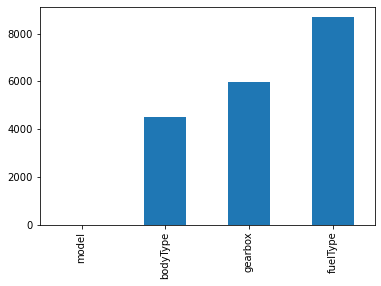

In [9]:
# nan visual
missing = Train_data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()


<AxesSubplot:>

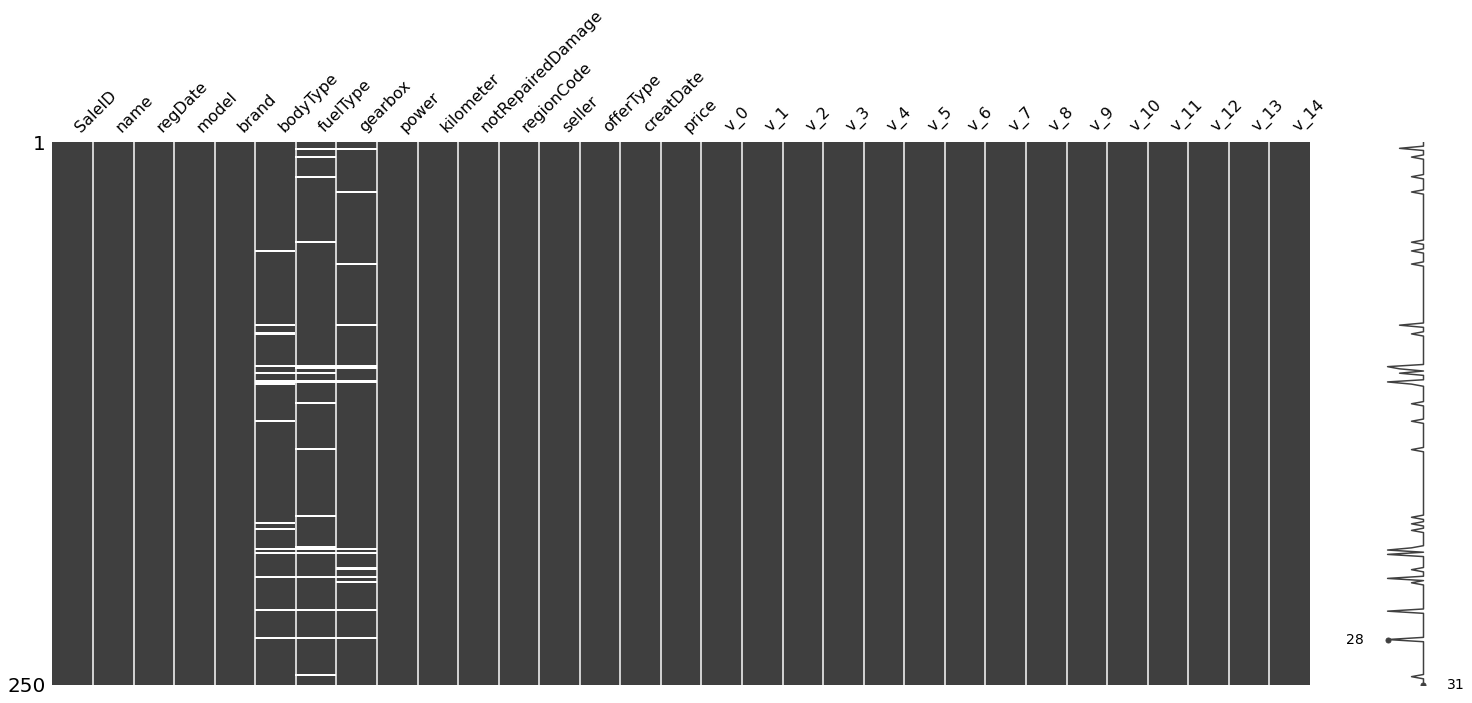

In [10]:
msno.matrix(Train_data.sample(250))

<AxesSubplot:>

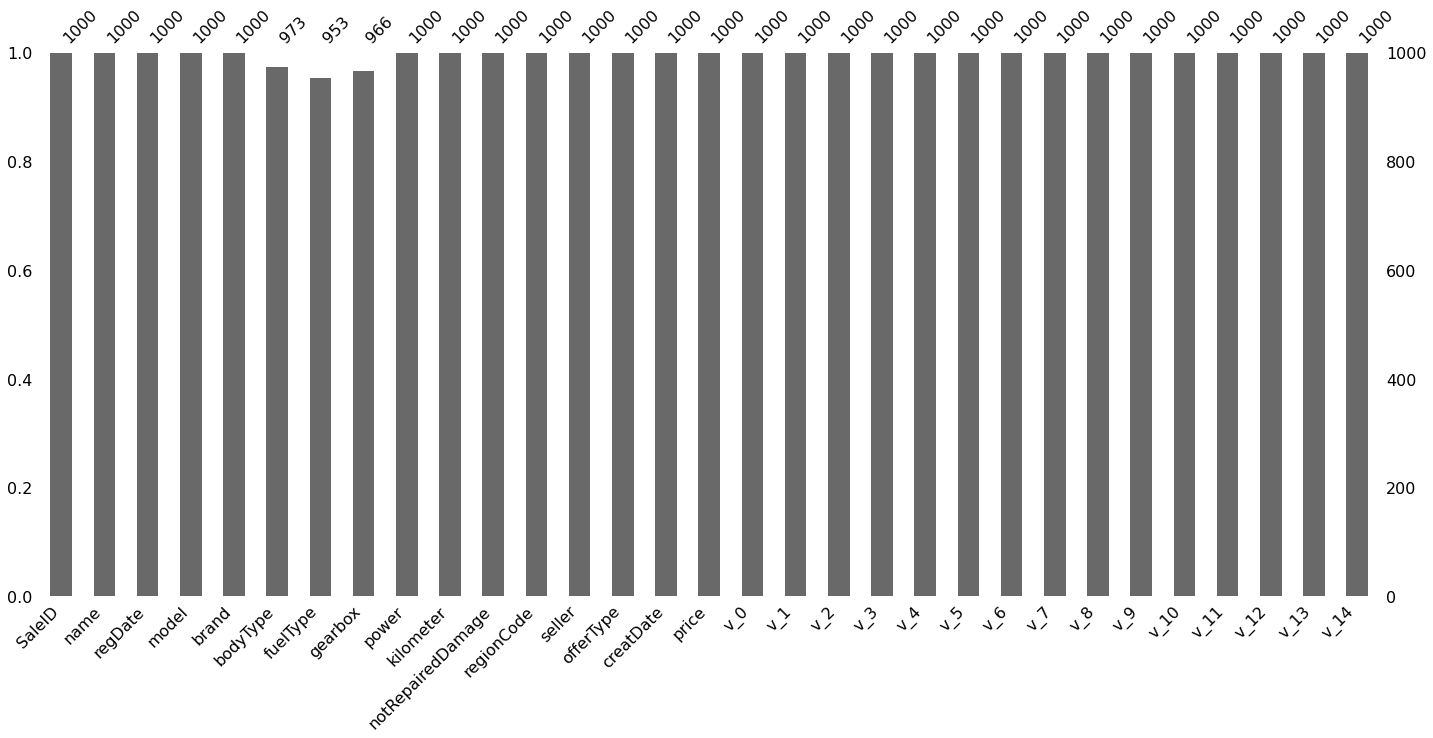

In [11]:
msno.bar(Train_data.sample(1000))

<AxesSubplot:>

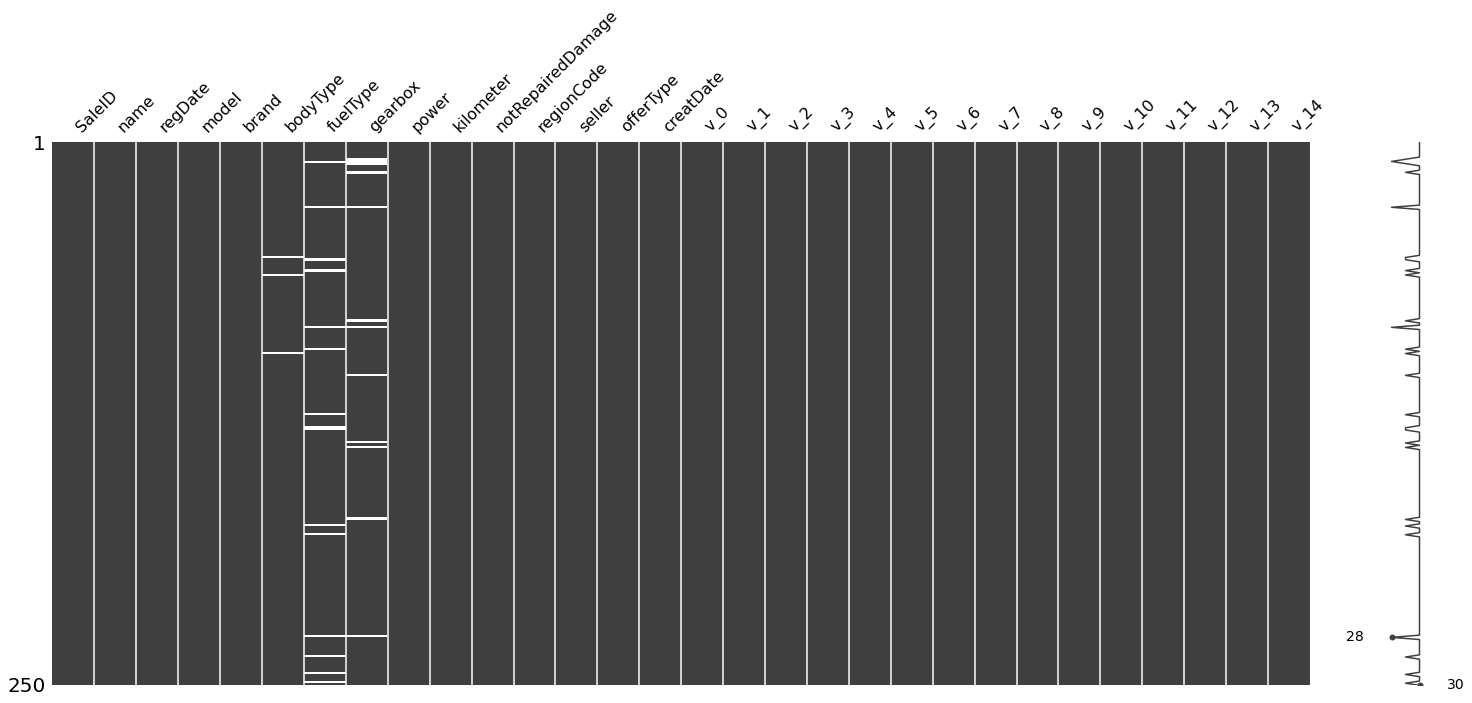

In [12]:
# 可视化看下缺省值
msno.matrix(Test_data.sample(250))

<AxesSubplot:>

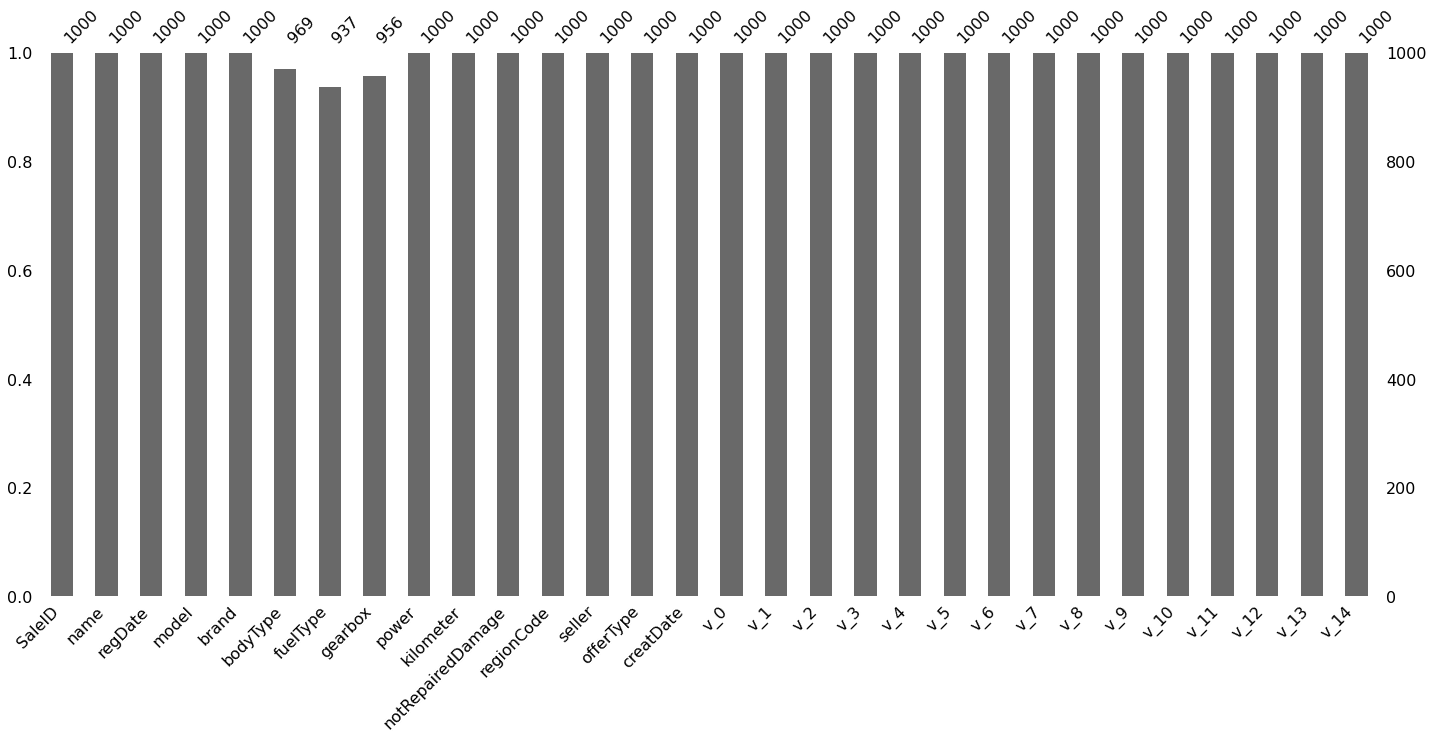

In [13]:
msno.bar(Test_data.sample(1000))

In [14]:
## 2) 查看异常值检测
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SaleID             150000 non-null  int64  
 1   name               150000 non-null  int64  
 2   regDate            150000 non-null  int64  
 3   model              149999 non-null  float64
 4   brand              150000 non-null  int64  
 5   bodyType           145494 non-null  float64
 6   fuelType           141320 non-null  float64
 7   gearbox            144019 non-null  float64
 8   power              150000 non-null  int64  
 9   kilometer          150000 non-null  float64
 10  notRepairedDamage  150000 non-null  object 
 11  regionCode         150000 non-null  int64  
 12  seller             150000 non-null  int64  
 13  offerType          150000 non-null  int64  
 14  creatDate          150000 non-null  int64  
 15  price              150000 non-null  int64  
 16  v_

In [15]:
Train_data['notRepairedDamage'].value_counts()

0.0    111361
-       24324
1.0     14315
Name: notRepairedDamage, dtype: int64

In [16]:
Train_data['notRepairedDamage'].replace('-', np.nan, inplace=True)

In [17]:
Train_data['notRepairedDamage'].value_counts()

0.0    111361
1.0     14315
Name: notRepairedDamage, dtype: int64

In [18]:
Train_data.isnull().sum()

SaleID                   0
name                     0
regDate                  0
model                    1
brand                    0
bodyType              4506
fuelType              8680
gearbox               5981
power                    0
kilometer                0
notRepairedDamage    24324
regionCode               0
seller                   0
offerType                0
creatDate                0
price                    0
v_0                      0
v_1                      0
v_2                      0
v_3                      0
v_4                      0
v_5                      0
v_6                      0
v_7                      0
v_8                      0
v_9                      0
v_10                     0
v_11                     0
v_12                     0
v_13                     0
v_14                     0
dtype: int64

In [19]:
Test_data['notRepairedDamage'].value_counts()

0.0    37224
-       8069
1.0     4707
Name: notRepairedDamage, dtype: int64

In [20]:
Test_data['notRepairedDamage'].replace('-', np.nan, inplace=True)

In [21]:
Train_data["seller"].value_counts()

0    149999
1         1
Name: seller, dtype: int64

In [22]:
Train_data["offerType"].value_counts()

0    150000
Name: offerType, dtype: int64

In [23]:
del Train_data["seller"]
del Train_data["offerType"]
del Test_data["seller"]
del Test_data["offerType"]

### look at target varibale

In [24]:
Train_data['price']

0         1850
1         3600
2         6222
3         2400
4         5200
          ... 
149995    5900
149996    9500
149997    7500
149998    4999
149999    4700
Name: price, Length: 150000, dtype: int64

In [25]:
Train_data['price'].value_counts()

500      2337
1500     2158
1200     1922
1000     1850
2500     1821
         ... 
9395        1
81900       1
16699       1
11998       1
14780       1
Name: price, Length: 3763, dtype: int64

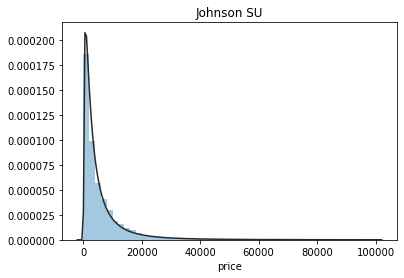

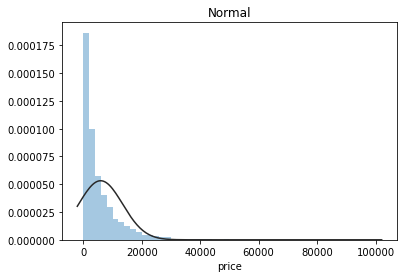

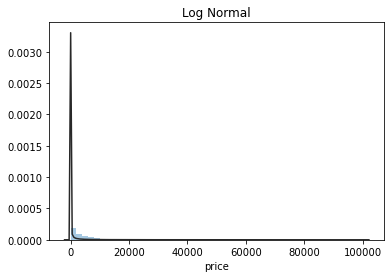

In [26]:
## 1) Distribution（Johnson Distribution）
import scipy.stats as st
y = Train_data['price']
plt.figure(1); plt.title('Johnson SU')

sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.savefig(r'../figures/JohnsonSU_price.png', dpi=300,format="PNG")

plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.savefig(r'../figures/Normal_price.png', dpi=300,format="PNG")

plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)
plt.savefig(r'../figures/Log_Normal_price.png', dpi=300,format="PNG")

Skewness: 3.346487
Kurtosis: 18.995183


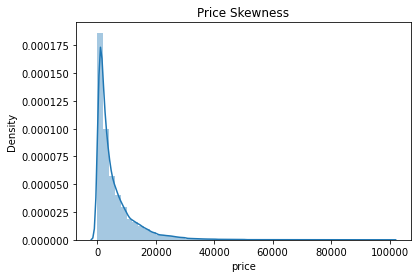

In [27]:
## 2) skewness and kurtosis
plt.figure; plt.title('Price Skewness')
sns.distplot(Train_data['price']);
plt.savefig(r'../figures/Price Skewness.png', dpi=300,format="PNG")
print("Skewness: %f" % Train_data['price'].skew())
print("Kurtosis: %f" % Train_data['price'].kurt())

In [28]:
Train_data.skew(), Train_data.kurt()

(SaleID                0.000000
 name                  0.557606
 regDate               0.028495
 model                 1.484388
 brand                 1.150760
 bodyType              0.991530
 fuelType              1.595486
 gearbox               1.317514
 power                65.863178
 kilometer            -1.525921
 notRepairedDamage     2.430640
 regionCode            0.688881
 creatDate           -79.013310
 price                 3.346487
 v_0                  -1.316712
 v_1                   0.359454
 v_2                   4.842556
 v_3                   0.106292
 v_4                   0.367989
 v_5                  -4.737094
 v_6                   0.368073
 v_7                   5.130233
 v_8                   0.204613
 v_9                   0.419501
 v_10                  0.025220
 v_11                  3.029146
 v_12                  0.365358
 v_13                  0.267915
 v_14                 -1.186355
 dtype: float64,
 SaleID                 -1.200000
 name                

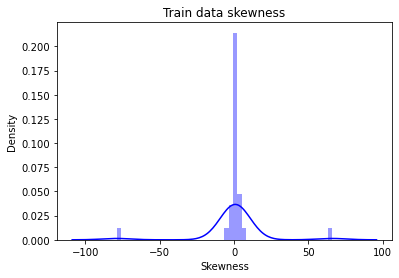

In [29]:
plt.figure; plt.title('Train data skewness')
sns.distplot(Train_data.skew(),color='blue',axlabel ='Skewness')
plt.savefig(r'../figures/Train data Skewness.png', dpi=300,format="PNG")

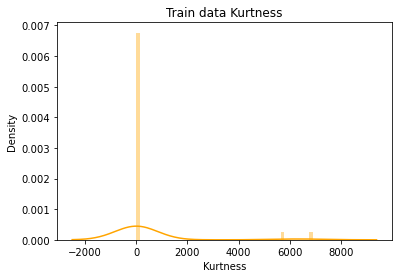

In [30]:
plt.figure; plt.title('Train data Kurtness')
sns.distplot(Train_data.kurt(),color='orange',axlabel ='Kurtness')
plt.savefig(r'../figures/Train data Kurtness.png', dpi=300,format="PNG")

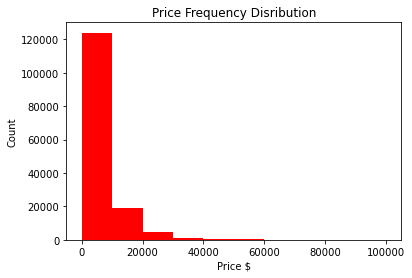

In [31]:
## 3) Price ferquency
plt.hist(Train_data['price'], orientation = 'vertical',histtype = 'bar', color ='red')
plt.xlabel('Price $')
plt.ylabel('Count')
plt.title('Price Frequency Disribution')
plt.savefig(r'../figures/Price Frequency.png', dpi=300,format="PNG")
plt.show()

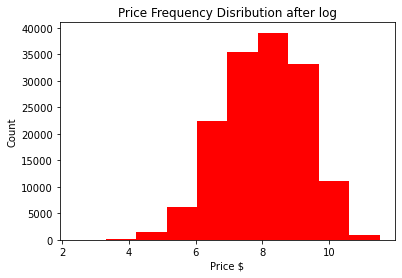

In [32]:
# after log transformation
plt.hist(np.log(Train_data['price']), orientation = 'vertical',histtype = 'bar', color ='red') 
plt.xlabel('Price $')
plt.ylabel('Count')
plt.title('Price Frequency Disribution after log')
plt.savefig(r'../figures/Price Frequency log.png', dpi=300,format="PNG")
plt.show()

### Features, continuous and categorical

In [33]:
Y_train = Train_data['price']

In [34]:
numeric_features = ['power', 'kilometer', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13','v_14' ]

categorical_features = ['name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'regionCode',]

In [35]:
# unique value in cate frts
for cat_fea in categorical_features:
    print(cat_fea + "的特征分布如下：")
    print("{}特征有个{}不同的值".format(cat_fea, Train_data[cat_fea].nunique()))
    print(Train_data[cat_fea].value_counts())

name的特征分布如下：
name特征有个99662不同的值
708       282
387       282
55        280
1541      263
203       233
         ... 
119983      1
63443       1
104410      1
154956      1
177672      1
Name: name, Length: 99662, dtype: int64
model的特征分布如下：
model特征有个248不同的值
0.0      11762
19.0      9573
4.0       8445
1.0       6038
29.0      5186
         ...  
240.0        2
209.0        2
245.0        2
242.0        2
247.0        1
Name: model, Length: 248, dtype: int64
brand的特征分布如下：
brand特征有个40不同的值
0     31480
4     16737
14    16089
10    14249
1     13794
6     10217
9      7306
5      4665
13     3817
11     2945
3      2461
7      2361
16     2223
8      2077
25     2064
27     2053
21     1547
15     1458
19     1388
20     1236
12     1109
22     1085
26      966
30      940
17      913
24      772
28      649
32      592
29      406
37      333
2       321
31      318
18      316
36      228
34      227
33      218
23      186
35      180
38       65
39        9
Name: brand, dtype: int64
body

In [36]:
# continuous frt
numeric_features.append('price')
numeric_features

['power',
 'kilometer',
 'v_0',
 'v_1',
 'v_2',
 'v_3',
 'v_4',
 'v_5',
 'v_6',
 'v_7',
 'v_8',
 'v_9',
 'v_10',
 'v_11',
 'v_12',
 'v_13',
 'v_14',
 'price']

In [37]:
Train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [38]:
## 1) 相关性分析
price_numeric = Train_data[numeric_features]
correlation = price_numeric.corr()
print(correlation['price'].sort_values(ascending = False),'\n')

price        1.000000
v_12         0.692823
v_8          0.685798
v_0          0.628397
power        0.219834
v_5          0.164317
v_2          0.085322
v_6          0.068970
v_1          0.060914
v_14         0.035911
v_13        -0.013993
v_7         -0.053024
v_4         -0.147085
v_9         -0.206205
v_10        -0.246175
v_11        -0.275320
kilometer   -0.440519
v_3         -0.730946
Name: price, dtype: float64 



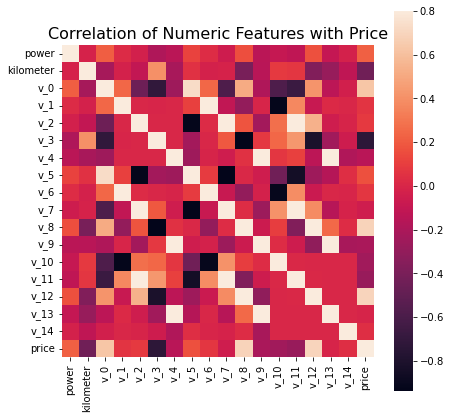

In [39]:
f , ax = plt.subplots(figsize = (7, 7))

plt.title('Correlation of Numeric Features with Price',y=1,size=16)


sns.heatmap(correlation,square = True,  vmax=0.8)
plt.savefig(r'../figures/Heatmap All Frts.png', dpi=300,format="PNG")

In [40]:
del price_numeric['price']

In [41]:
## 2) skewness
for col in numeric_features:
    print('{:15}'.format(col), 
          'Skewness: {:05.2f}'.format(Train_data[col].skew()) , 
          '   ' ,
          'Kurtosis: {:06.2f}'.format(Train_data[col].kurt())  
         )

power           Skewness: 65.86     Kurtosis: 5733.45
kilometer       Skewness: -1.53     Kurtosis: 001.14
v_0             Skewness: -1.32     Kurtosis: 003.99
v_1             Skewness: 00.36     Kurtosis: -01.75
v_2             Skewness: 04.84     Kurtosis: 023.86
v_3             Skewness: 00.11     Kurtosis: -00.42
v_4             Skewness: 00.37     Kurtosis: -00.20
v_5             Skewness: -4.74     Kurtosis: 022.93
v_6             Skewness: 00.37     Kurtosis: -01.74
v_7             Skewness: 05.13     Kurtosis: 025.85
v_8             Skewness: 00.20     Kurtosis: -00.64
v_9             Skewness: 00.42     Kurtosis: -00.32
v_10            Skewness: 00.03     Kurtosis: -00.58
v_11            Skewness: 03.03     Kurtosis: 012.57
v_12            Skewness: 00.37     Kurtosis: 000.27
v_13            Skewness: 00.27     Kurtosis: -00.44
v_14            Skewness: -1.19     Kurtosis: 002.39
price           Skewness: 03.35     Kurtosis: 019.00


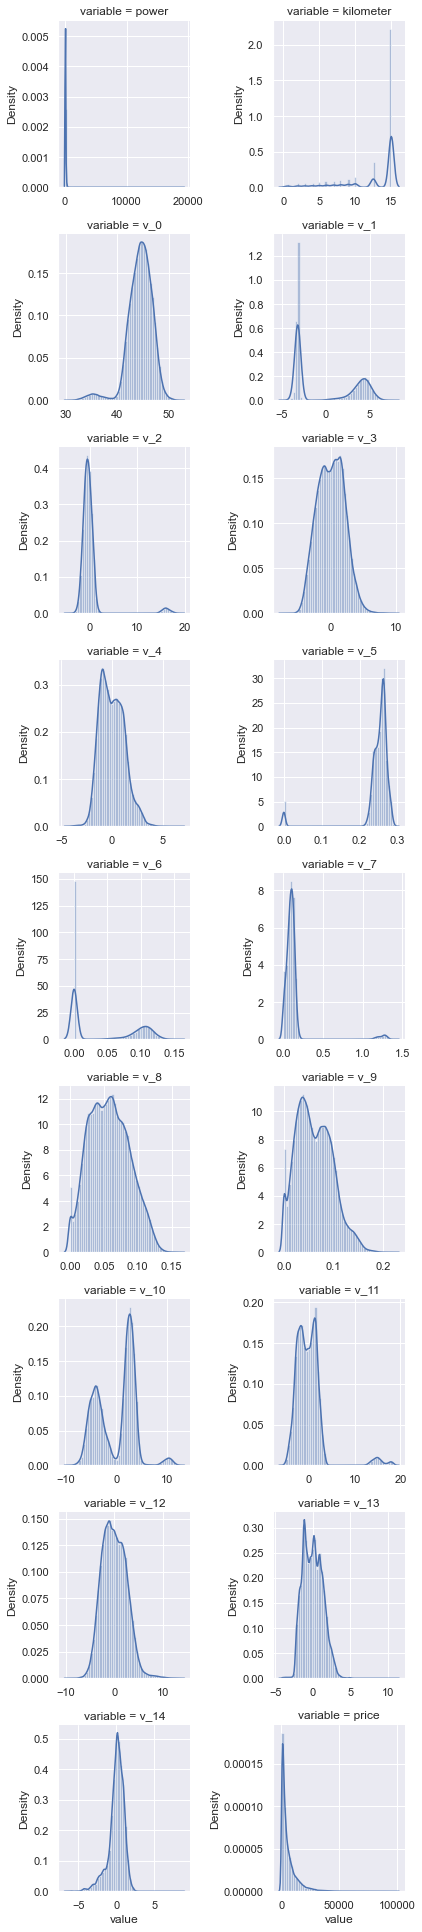

In [42]:
## 3) num frt visual
f = pd.melt(Train_data, value_vars=numeric_features)
sns.set(rc = {'figure.figsize':(10,10)})
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
plt.savefig(r'../figures/cont frt.png',dpi=300,format="PNG")

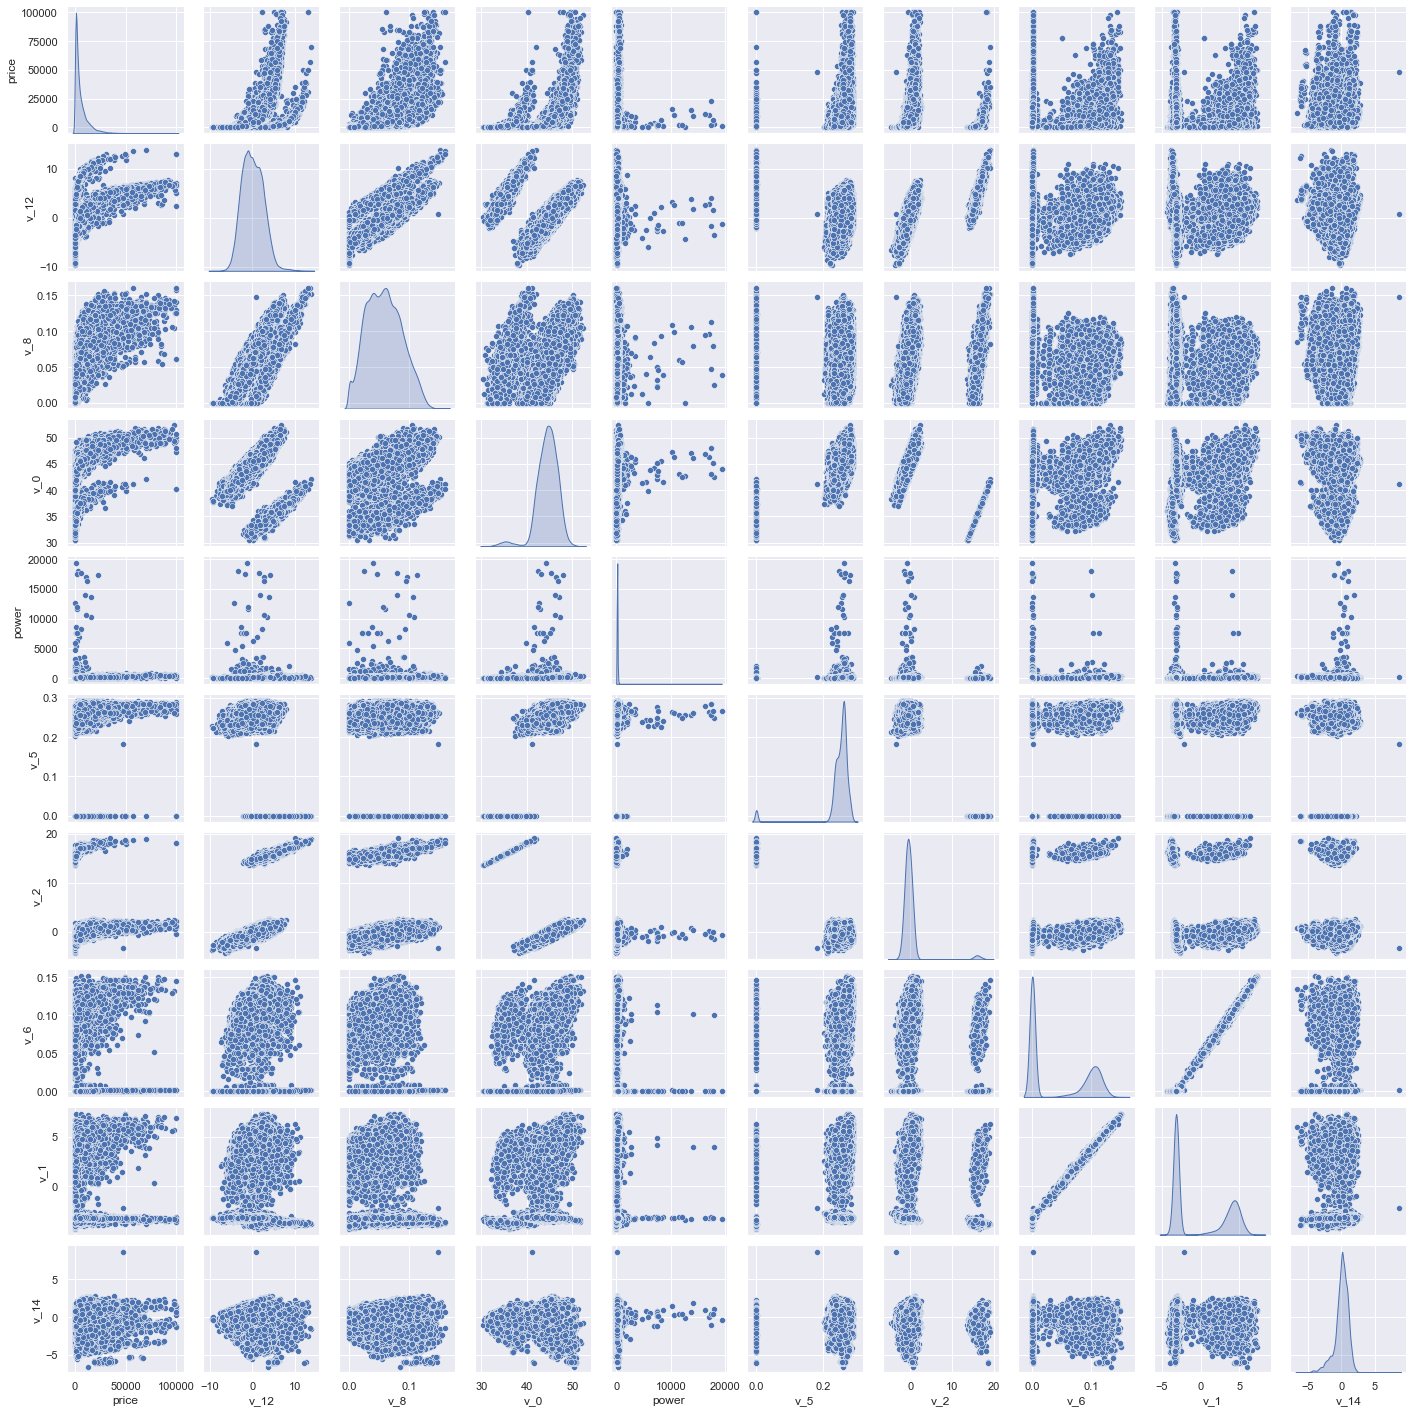

In [43]:
## 4) num-num relation visual
sns.set(rc = {'figure.figsize':(10,10)})
columns = ['price', 'v_12', 'v_8' , 'v_0', 'power', 'v_5',  'v_2', 'v_6', 'v_1', 'v_14']
sns.pairplot(Train_data[columns],size = 2 ,kind ='scatter',diag_kind='kde')
plt.savefig(r'../figures/cont frt corr.png',dpi=300,format="PNG")
plt.show()

In [44]:
Train_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6',
       'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14'],
      dtype='object')

In [45]:
Y_train

0         1850
1         3600
2         6222
3         2400
4         5200
          ... 
149995    5900
149996    9500
149997    7500
149998    4999
149999    4700
Name: price, Length: 150000, dtype: int64

### Categorical frt analysis

In [46]:
## 1) unique分布
for fea in categorical_features:
    print(Train_data[fea].nunique())

99662
248
40
8
7
2
2
7905


In [47]:
categorical_features

['name',
 'model',
 'brand',
 'bodyType',
 'fuelType',
 'gearbox',
 'notRepairedDamage',
 'regionCode']

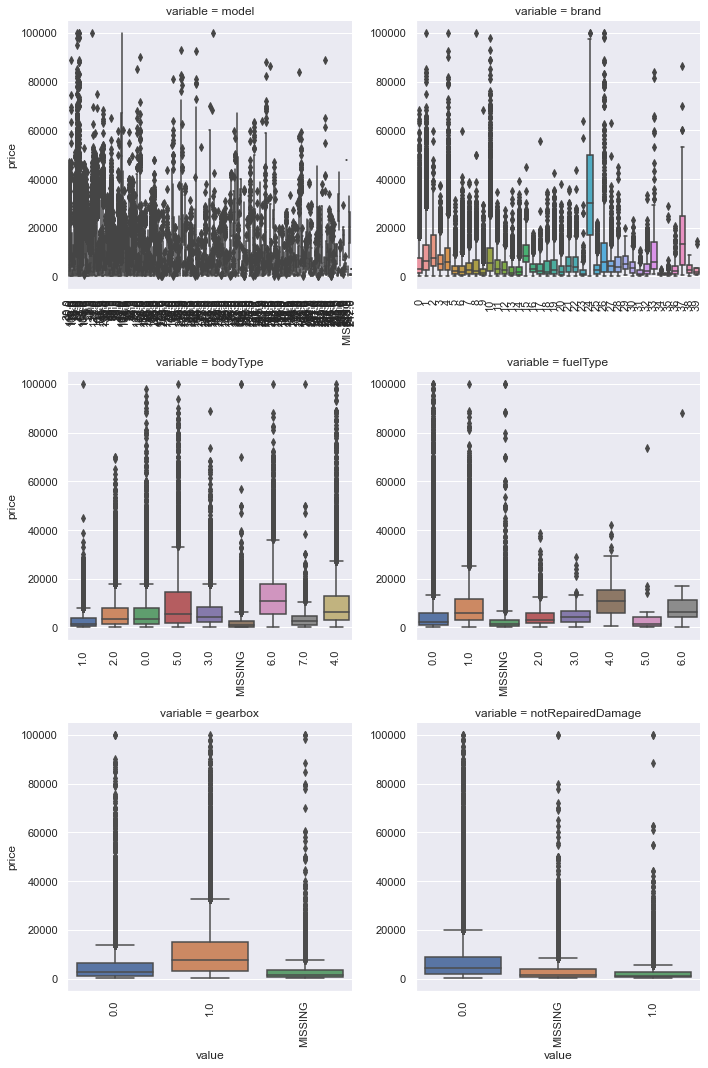

In [48]:
## 2) cate box plot
categorical_features = ['model',
 'brand',
 'bodyType',
 'fuelType',
 'gearbox',
 'notRepairedDamage']
for c in categorical_features:
    Train_data[c] = Train_data[c].astype('category')
    if Train_data[c].isnull().any():
        Train_data[c] = Train_data[c].cat.add_categories(['MISSING'])
        Train_data[c] = Train_data[c].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

f = pd.melt(Train_data, id_vars=['price'], value_vars=categorical_features)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "price")
plt.savefig(r'../figures/cat frt box.png',dpi=300,format="PNG")

In [49]:
Train_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6',
       'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14'],
      dtype='object')

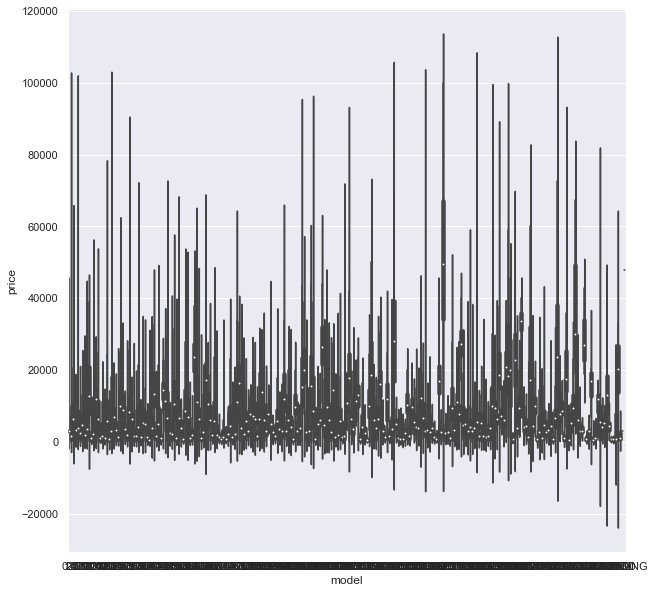

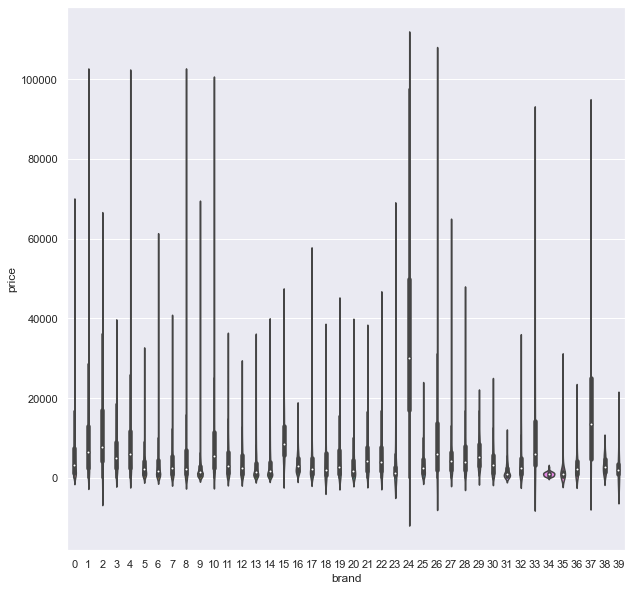

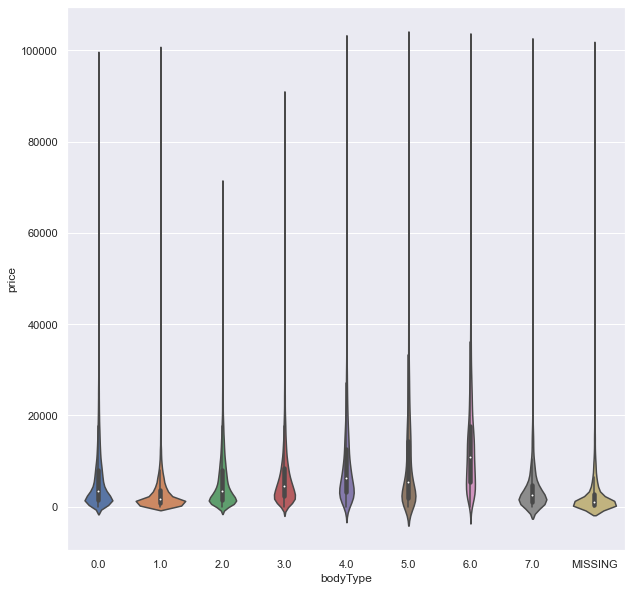

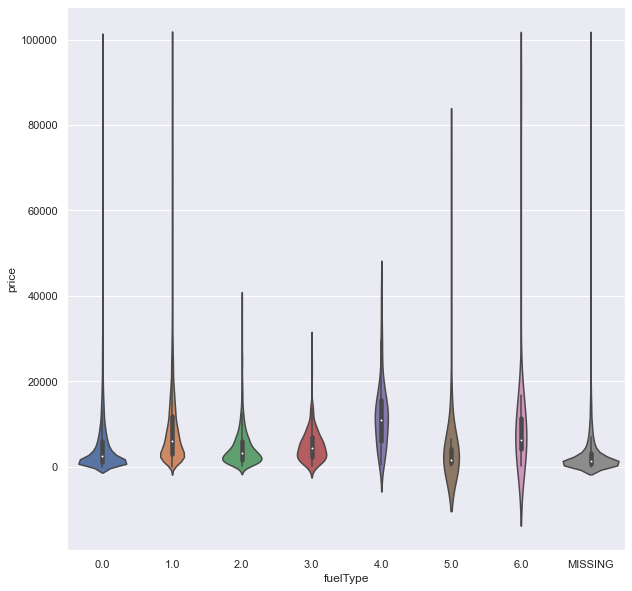

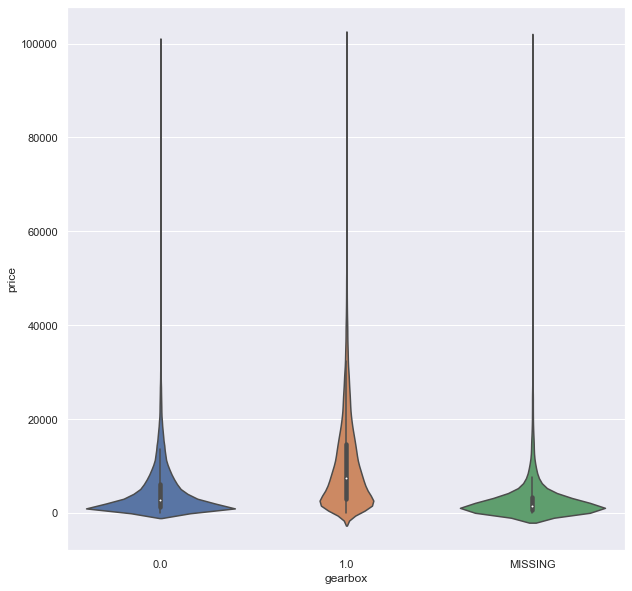

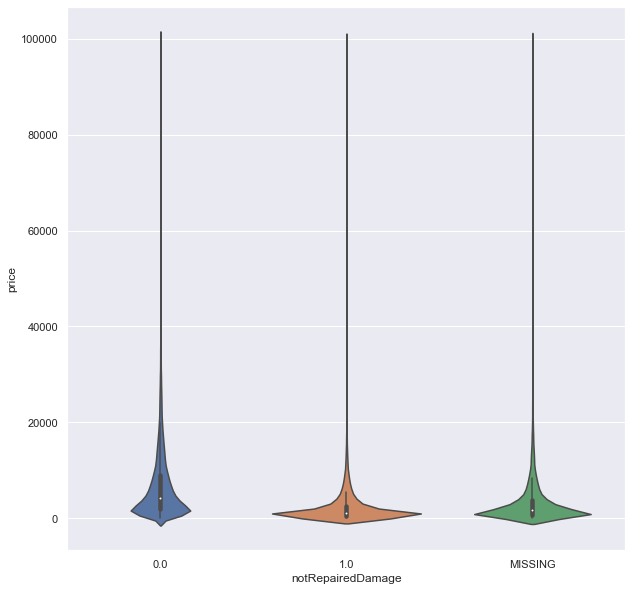

In [50]:
## 3) cate violin
catg_list = categorical_features
target = 'price'
for catg in catg_list :
    sns.violinplot(x=catg, y=target, data=Train_data)
    plt.savefig(r'../figures/cont frt voline %d.png',dpi=300,format="PNG")
    plt.show()

In [51]:
categorical_features = ['model',
 'brand',
 'bodyType',
 'fuelType',
 'gearbox',
 'notRepairedDamage']

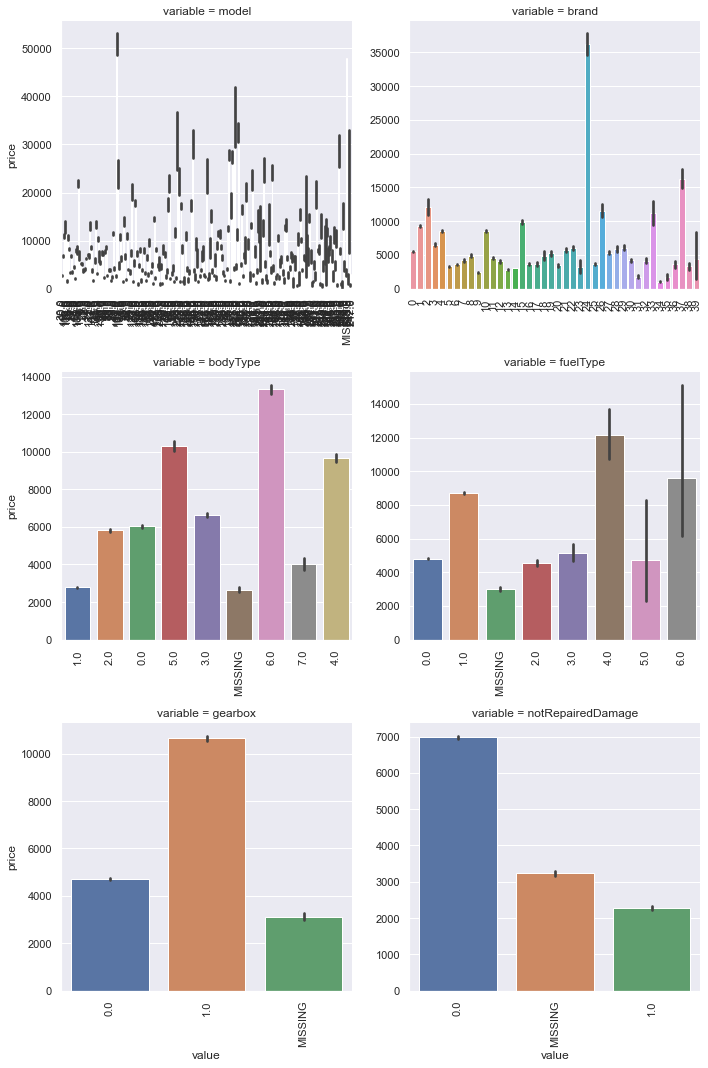

In [52]:
## 4) cate hist
def bar_plot(x, y, **kwargs):
    sns.barplot(x=x, y=y)
    x=plt.xticks(rotation=90)

f = pd.melt(Train_data, id_vars=['price'], value_vars=categorical_features)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)

g = g.map(bar_plot, "value", "price")
plt.savefig(r'../figures/cont frt hist.png',dpi=300,format="PNG")

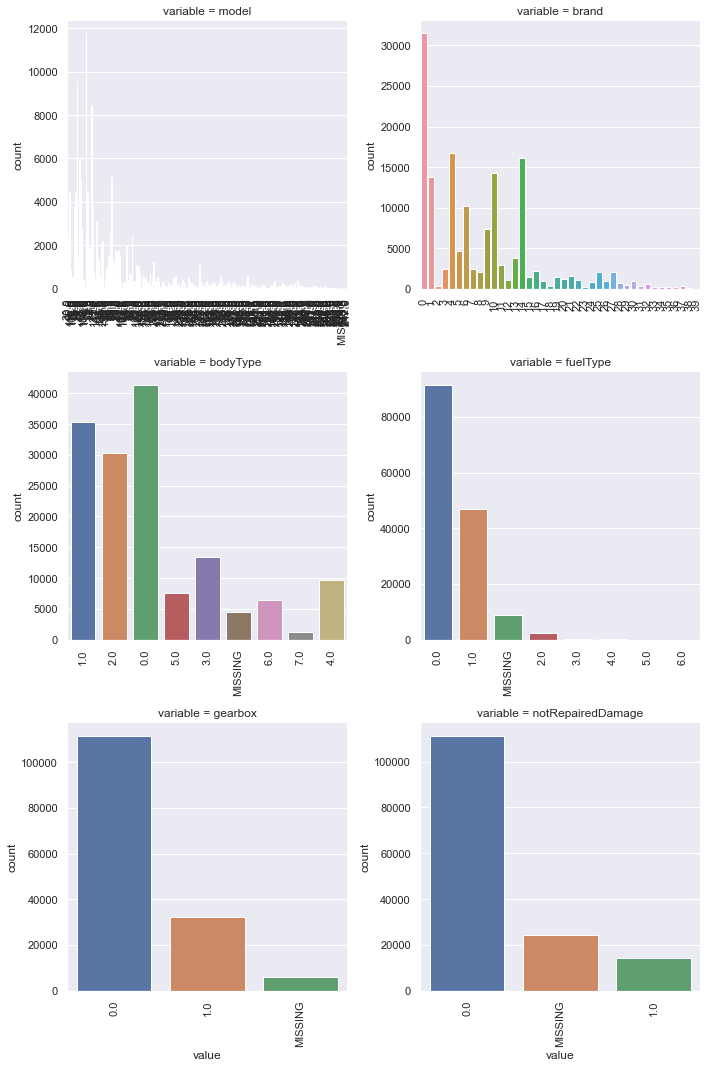

In [53]:
##  5) cate (count_plot)
def count_plot(x,  **kwargs):
    sns.countplot(x=x)
    x=plt.xticks(rotation=90)

f = pd.melt(Train_data,  value_vars=categorical_features)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)

g = g.map(count_plot, "value")
plt.savefig(r'../figures/cont frt frequency.png',dpi=300,format="PNG")

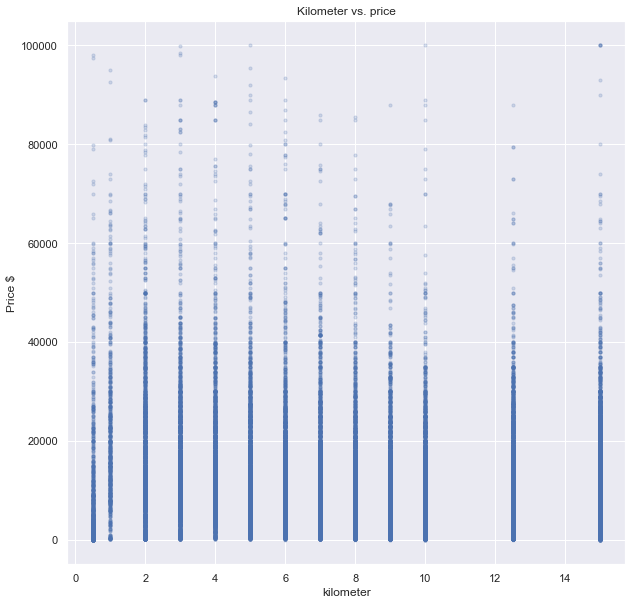

In [54]:
# ------- continuous vs. continuous -----------------
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

Train_data.plot.scatter('kilometer','price',s=10,alpha=0.2) # alpha=0.1(透明度),s=10（点大小）
plt.ylabel("Price $")
plt.title("Kilometer vs. price")
plt.savefig(r'../figures/scatter_plot_kvsp.png', dpi=300,format="PNG")
plt.show()


## Data Preprocessing

### Delete outliers

In [55]:
# deal outliers。
def outliers_proc(data, col_name, scale=3):
    """
    用于清洗异常值，默认用 box_plot（scale=3）进行清洗
    :param data: 接收 pandas 数据格式
    :param col_name: pandas 列名
    :param scale: 尺度
    :return:
    """

    def box_plot_outliers(data_ser, box_scale):
        """
        利用箱线图去除异常值
        :param data_ser: 接收 pandas.Series 数据格式
        :param box_scale: 箱线图尺度，
        :return:
        """
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up)
        return (rule_low, rule_up), (val_low, val_up)

    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print("Delete number is: {}".format(len(index)))
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    print("Now column number is: {}".format(data_n.shape[0]))
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("Description of data less than the lower bound is:")
    print(pd.Series(outliers).describe())
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("Description of data larger than the upper bound is:")
    print(pd.Series(outliers).describe())
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1])
    return data_n

Delete number is: 963
Now column number is: 149037
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64
Description of data larger than the upper bound is:
count      963.000000
mean       846.836968
std       1929.418081
min        376.000000
25%        400.000000
50%        436.000000
75%        514.000000
max      19312.000000
Name: power, dtype: float64


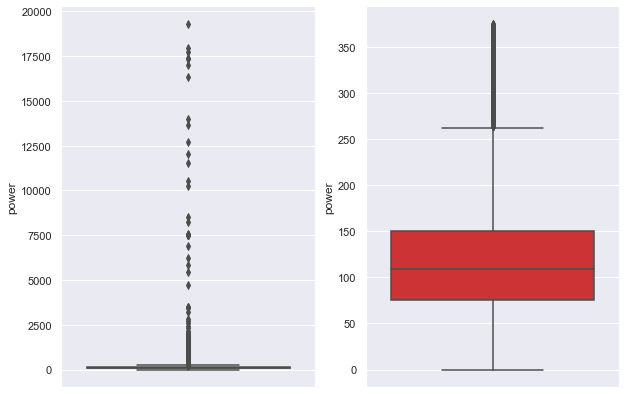

In [56]:
# delete outliers

Train_data = outliers_proc(Train_data, 'power', scale=3)

### Feature Engineering

In [57]:
# concate train test
Train_data['train']=1
Test_data['train']=0
data = pd.concat([Train_data, Test_data], ignore_index=True)

In [58]:
# using time length：data['creatDate'] - data['regDate']，price decrease if using time increase
data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d', errors='coerce') - 
                            pd.to_datetime(data['regDate'], format='%Y%m%d', errors='coerce')).dt.days

In [59]:
# 15k null over 7.5% not deleting。
# XGB deal with it
data['used_time'].isnull().sum()

15054

In [60]:
# find city info from zip code
data['city'] = data['regionCode'].apply(lambda x : str(x)[:-3])
data = data

In [61]:
# calculate sale amount of a brand
Train_gb = Train_data.groupby("brand")
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['brand_amount'] = len(kind_data)
    info['brand_price_max'] = kind_data.price.max()
    info['brand_price_median'] = kind_data.price.median()
    info['brand_price_min'] = kind_data.price.min()
    info['brand_price_sum'] = kind_data.price.sum()
    info['brand_price_std'] = kind_data.price.std()
    info['brand_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "brand"})
data = data.merge(brand_fe, how='left', on='brand')

In [62]:
# Data bucketing Take power as an example
# At this time our missing values are also in the bucket

# 1. After the discretization, the sparse vector inner product multiplication operation speed is faster, 
#   and the calculation results are also convenient to store and easy to expand;
# 2. Discrete features are more robust to outliers, such as age>30 is 1, otherwise it is 0, and the model 
#    with an age of 200 will not cause great interference to the model;
# 3. LR is a generalized linear model with limited expressive ability. After discretization, each variable
#    has a separate weight, which is equivalent to introducing nonlinearity, which can improve the expressive 
#    ability of the model and increase the fitting;
# 4. After the discrete features, feature crossover can be carried out to improve expressive ability.
#    M*N variables are programmed from M+N variables, and non-linear shapes are further introduced to improve expressive ability;
# 5. The model is more stable after the features are discrete. For example, the user age range will
#     not change because the user’s age is one year older.
bin = [i*10 for i in range(31)]
data['power_bin'] = pd.cut(data['power'], bin, labels=False)
data[['power_bin', 'power']].head()

,power_bin,power
0,5.0,60
1,NaN,0
2,16.0,163
3,19.0,193
4,6.0,68


In [63]:
# delte redundant
data = data.drop(['creatDate', 'regDate', 'regionCode'], axis=1)

In [64]:
print(data.shape)
data.columns

(199037, 37)


Index(['SaleID', 'name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox',
       'power', 'kilometer', 'notRepairedDamage', 'price', 'v_0', 'v_1', 'v_2',
       'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14', 'train', 'used_time', 'city', 'brand_amount',
       'brand_price_max', 'brand_price_median', 'brand_price_min',
       'brand_price_sum', 'brand_price_std', 'brand_price_average',
       'power_bin'],
      dtype='object')

In [65]:
# save data for tree model 
data.to_csv(r'../data/data_for_tree.csv', index=0)

<AxesSubplot:ylabel='Frequency'>

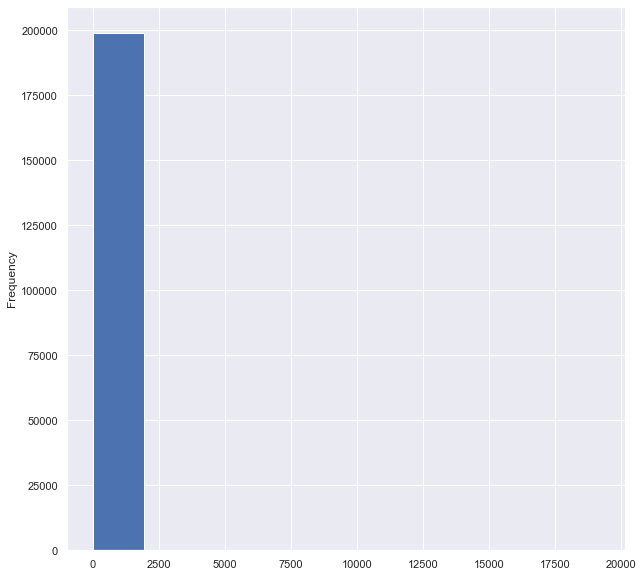

In [66]:
# data for lr nn, but tree model data also can be used for lr nn 
data['power'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

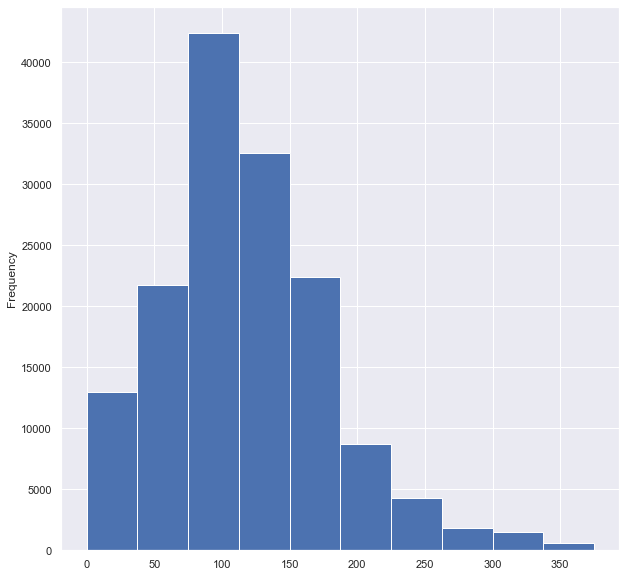

In [67]:
# outliers in test
Train_data['power'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

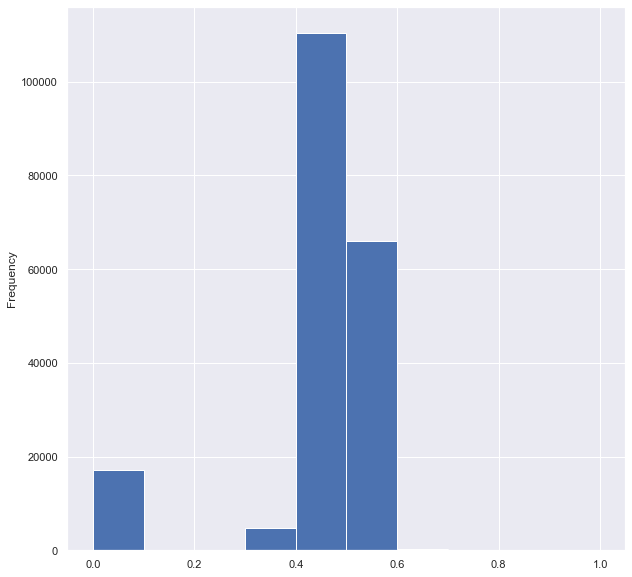

In [68]:
# get log of it and normalize
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data['power'] = np.log(data['power'] + 1) 
data['power'] = ((data['power'] - np.min(data['power'])) / (np.max(data['power']) - np.min(data['power'])))
data['power'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

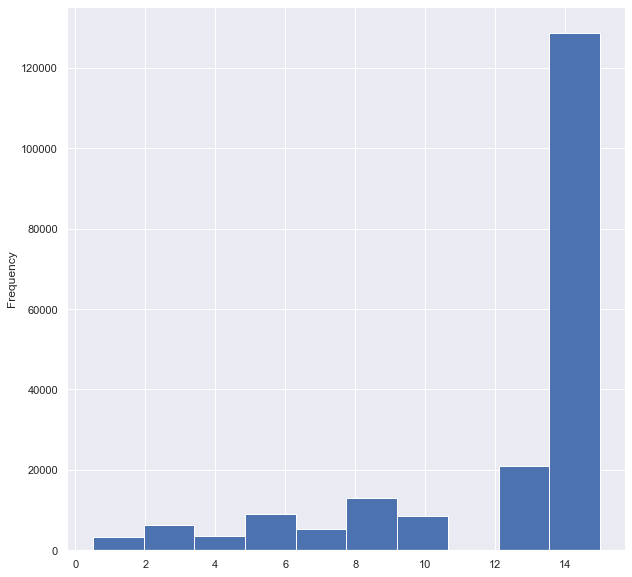

In [69]:
# normal 
data['kilometer'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

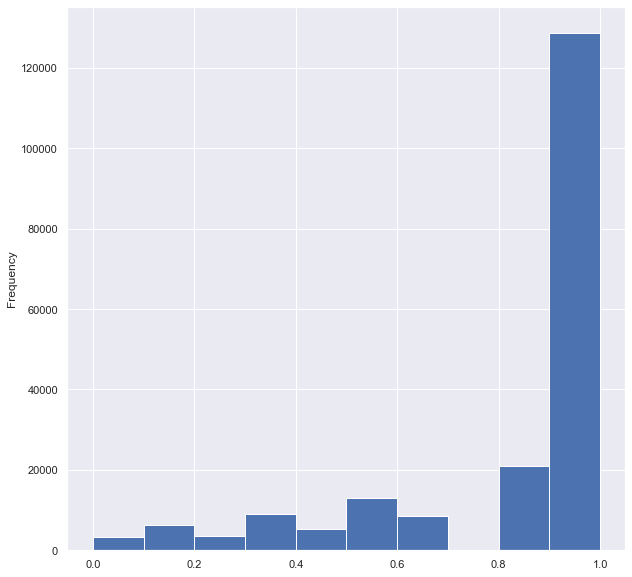

In [70]:
# normalize km
data['kilometer'] = ((data['kilometer'] - np.min(data['kilometer'])) / 
                        (np.max(data['kilometer']) - np.min(data['kilometer'])))
data['kilometer'].plot.hist()

In [71]:

# 'brand_amount', 'brand_price_average', 'brand_price_max',
# 'brand_price_median', 'brand_price_min', 'brand_price_std',
# 'brand_price_sum'
# self-define min max
def max_min(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

data['brand_amount'] = ((data['brand_amount'] - np.min(data['brand_amount'])) / 
                        (np.max(data['brand_amount']) - np.min(data['brand_amount'])))
data['brand_price_average'] = ((data['brand_price_average'] - np.min(data['brand_price_average'])) / 
                               (np.max(data['brand_price_average']) - np.min(data['brand_price_average'])))
data['brand_price_max'] = ((data['brand_price_max'] - np.min(data['brand_price_max'])) / 
                           (np.max(data['brand_price_max']) - np.min(data['brand_price_max'])))
data['brand_price_median'] = ((data['brand_price_median'] - np.min(data['brand_price_median'])) /
                              (np.max(data['brand_price_median']) - np.min(data['brand_price_median'])))
data['brand_price_min'] = ((data['brand_price_min'] - np.min(data['brand_price_min'])) / 
                           (np.max(data['brand_price_min']) - np.min(data['brand_price_min'])))
data['brand_price_std'] = ((data['brand_price_std'] - np.min(data['brand_price_std'])) / 
                           (np.max(data['brand_price_std']) - np.min(data['brand_price_std'])))
data['brand_price_sum'] = ((data['brand_price_sum'] - np.min(data['brand_price_sum'])) / 
                           (np.max(data['brand_price_sum']) - np.min(data['brand_price_sum'])))

In [72]:
# cate frts one hot 
data = pd.get_dummies(data, columns=['model', 'brand', 'bodyType', 'fuelType',
                                     'gearbox', 'notRepairedDamage', 'power_bin'])

In [73]:
print(data.shape)
data.columns

(199037, 372)


Index(['SaleID', 'name', 'power', 'kilometer', 'price', 'v_0', 'v_1', 'v_2',
       'v_3', 'v_4',
       ...
       'power_bin_20.0', 'power_bin_21.0', 'power_bin_22.0', 'power_bin_23.0',
       'power_bin_24.0', 'power_bin_25.0', 'power_bin_26.0', 'power_bin_27.0',
       'power_bin_28.0', 'power_bin_29.0'],
      dtype='object', length=372)

In [74]:
# for lr
data.to_csv(r'../data/data_for_lr.csv', index=0)

### Feature selection

In [75]:
# correlation
print(data['power'].corr(data['price'], method='spearman'))
print(data['kilometer'].corr(data['price'], method='spearman'))
print(data['brand_amount'].corr(data['price'], method='spearman'))
print(data['brand_price_average'].corr(data['price'], method='spearman'))
print(data['brand_price_max'].corr(data['price'], method='spearman'))
print(data['brand_price_median'].corr(data['price'], method='spearman'))

0.5728285196051496
-0.4082569701616764
0.058156610025581514
0.3834909576057687
0.259066833880992
0.38691042393409447


<AxesSubplot:title={'center':'Correlation of Numeric Features with Price'}>

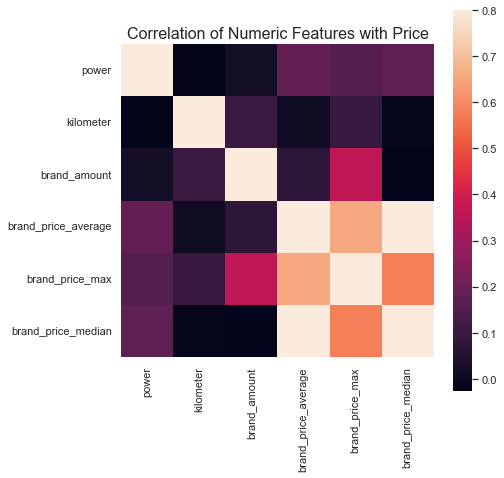

In [76]:
# heatmap
data_numeric = data[['power', 'kilometer', 'brand_amount', 'brand_price_average', 
                     'brand_price_max', 'brand_price_median']]
correlation = data_numeric.corr()

f , ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)

In [77]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [78]:
sample_feature = reduce_mem_usage(pd.read_csv(r'../data/data_for_tree.csv'))

Memory usage of dataframe is 58915080.00 MB
Memory usage after optimization is: 15547254.00 MB
Decreased by 73.6%


In [79]:
continuous_feature_names = [x for x in sample_feature.columns if x not in ['price','brand','model','brand']]

In [80]:
sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True)
sample_feature = sample_feature.dropna().replace('MISSING', 0).reset_index(drop=True)
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float64)
dfm = sample_feature[continuous_feature_names + ['price']]

X = dfm[continuous_feature_names]
y = dfm['price']

In [85]:
X.shape

(96267, 34)

In [81]:
def MLpipe_KFold_R2(X, y,  ML_algo, param_grid):
    '''
    This function splits the data to other/test (80/20) and then applies KFold with 5 folds to other.
    The r2 is minimized in cross-validation.
    '''
    
    test_scores = np.zeros(5)
    best_models = []

    for i in range(5):
        print('randoms state '+str(i+5))

        # first split to separate out the training set
        X_other, X_test, y_other, y_test = train_test_split(X,y,train_size = 0.8,random_state=42*i)

        # splitter for other
        kf = KFold(n_splits=5,shuffle=True,random_state=42*i)

        try:
            Reg_algo = ML_algo(random_state = 42*i)
        except:
            Reg_algo = ML_algo()

        # put together a pipeline using regressor, will be Reg_algo assigned above
        pipe = make_pipeline(Reg_algo)

        # prepare gridsearch, crossvalidation = kfold
        # n_jobs: Number of jobs to run in parallel. -1 means using all processors
        # neg_mean_squared_error which return the negated value of the metric
        grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'r2',
                            n_jobs=-1, verbose=True, cv=kf, return_train_score = True)

        # do kfold CV on X_other and y_other
        grid.fit(X_other, y_other)
        # save results into a data frame. feel free to print it and inspect it
        results = pd.DataFrame(grid.cv_results_)

        print('best model parameters:',grid.best_params_)
    
        print('R2 score:',-1 * grid.best_score_)
        
        # save the model
        best_models.append(grid)
        # calculate and save the test score
        y_test_pred = best_models[-1].predict(X_test)
        test_scores[i] = r2_score(y_test,y_test_pred)
        print('test score:',test_scores[i])

    return best_models, test_scores



In [82]:
param_grid = {'lasso__alpha': np.logspace(-5,5,25)}
best_models_lasso,test_scores_lasso = MLpipe_KFold_R2(X, y, Lasso, param_grid)
print("The mean and std of the Lasso test scores are: ",np.mean(test_scores_lasso), "and", np.std(test_scores_lasso))

randoms state 5
Fitting 5 folds for each of 25 candidates, totalling 125 fits
best model parameters: {'lasso__alpha': 1e-05}
R2 score: -0.740141264667327
test score: 0.7467549446051005
randoms state 6
Fitting 5 folds for each of 25 candidates, totalling 125 fits
best model parameters: {'lasso__alpha': 1e-05}
R2 score: -0.7429012484074212
test score: 0.7368729352933854
randoms state 7
Fitting 5 folds for each of 25 candidates, totalling 125 fits
best model parameters: {'lasso__alpha': 1e-05}
R2 score: -0.7414775209362039
test score: 0.7418091019299731
randoms state 8
Fitting 5 folds for each of 25 candidates, totalling 125 fits
best model parameters: {'lasso__alpha': 1e-05}
R2 score: -0.7410867875740719
test score: 0.7439128865996255
randoms state 9
Fitting 5 folds for each of 25 candidates, totalling 125 fits
best model parameters: {'lasso__alpha': 1e-05}
R2 score: -0.7415122990238949
test score: 0.7416599428798141
The mean and std of the Lasso test scores are:  0.7422019622615796 and 

In [83]:
param_grid = {'ridge__alpha': np.logspace(-5,5,25)}
best_models_ridge,test_scores_ridge = MLpipe_KFold_R2(X, y, Ridge, param_grid)
print("The mean and std of the Ridge test scores are: ",np.mean(test_scores_ridge), "and", np.std(test_scores_ridge))

randoms state 5
Fitting 5 folds for each of 25 candidates, totalling 125 fits
best model parameters: {'ridge__alpha': 1e-05}
R2 score: -0.7498378611912502
test score: 0.7549968912516996
randoms state 6
Fitting 5 folds for each of 25 candidates, totalling 125 fits
best model parameters: {'ridge__alpha': 1e-05}
R2 score: -0.7522545417636133
test score: 0.7464121558136539
randoms state 7
Fitting 5 folds for each of 25 candidates, totalling 125 fits
best model parameters: {'ridge__alpha': 1e-05}
R2 score: -0.7506979900701919
test score: 0.7517138813168143
randoms state 8
Fitting 5 folds for each of 25 candidates, totalling 125 fits
best model parameters: {'ridge__alpha': 1e-05}
R2 score: -0.7505884997780345
test score: 0.7529343205278425
randoms state 9
Fitting 5 folds for each of 25 candidates, totalling 125 fits
best model parameters: {'ridge__alpha': 2.6101572156825386e-05}
R2 score: -0.7505547567992813
test score: 0.7517279596788913
The mean and std of the Ridge test scores are:  0.751

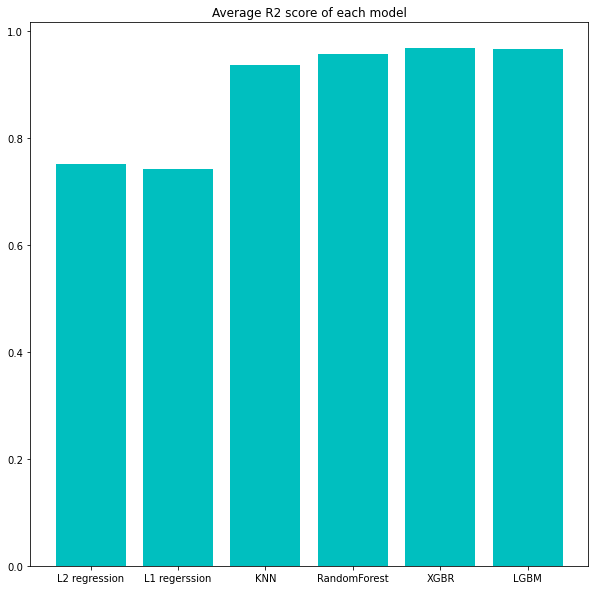

In [15]:
cols = ['L2 regression', 'L1 regerssion','KNN','RandomForest', 'XGBR', 'LGBM']
scoreall = [0.7515570417177803, 0.7422019622615796,0.9365362335837746,0.9574660105279242,0.9686802814024009,0.9672669746915307]
sc = pd.DataFrame(scoreall)

fig =plt.figure(figsize=(10,10))
plt.title("Average R2 score of each model")
plt.bar(cols,scoreall,color = 'c')
plt.savefig(r'../results/model_score_result.png', dpi=300,format="PNG")
plt.show()

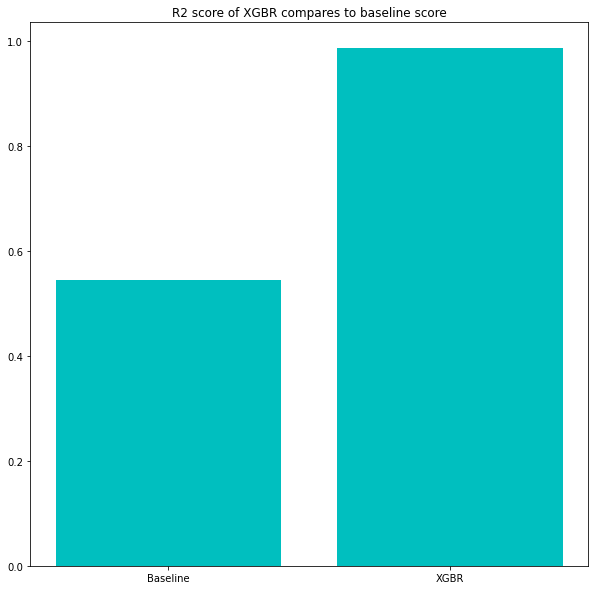

In [30]:
cols3 = ['Baseline', 'XGBR']
score3 = [0.5444997251431669, 0.9870766272099433]
sc3 = pd.DataFrame(score3)

fig =plt.figure(figsize=(10,10))
plt.title("R2 score of XGBR compares to baseline score")
plt.bar(cols3,score3,color = 'c')
plt.savefig(r'../results/model_score_baseline.png', dpi=300,format="PNG")
plt.show()